# LkHa Model Spectra

### Caltech Summer 2019

Written 8 February 2020. Also tests another way to get rid of the broadening problem.

### Imports 

In [18]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import integrate
from scipy import signal
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from fu_ori_functions_oct11 import *
from fu_ori_classes_oct11 import *
import matplotlib.gridspec as gridspec
from PyAstronomy import pyasl
import spectres

### Constants (astronomy is in cgs, right?)

In [19]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16
sec_YEAR = 365*24*60*60

In [20]:
DIREC = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/'

In [21]:
ATM_TABLE = dict()
ATMOS_FACTOR = 100

In [22]:
def direcToArray(directory):
    for temp in range(2000, 10000+ATMOS_FACTOR, ATMOS_FACTOR):
        for grav in [1.5, 4.0]:
            try:
                atmos_file = directory + 'pr.lte' + str(int(temp/ATMOS_FACTOR)) \
                        + '-' + str(grav) + '-0.0.spec'
                txt = open(atmos_file)
                fulltxt = txt.readlines()
                # Cleaning lines
                newtxt = []
                for i in range(len(fulltxt)):
                    line = fulltxt[i][:-1]
                    line = line.split()
                    newtxt.append(line)
        
                # Casting as floats
                newtxt = np.array(newtxt).astype(np.float64)
                
                # Choosing which model to use
                wav, lum = newtxt[:,0], newtxt[:,1]
                ATM_TABLE[(temp, grav)] = np.array([wav, lum])
            except:
                print('No atmosphere found for temp = ' + str(temp) + \
                      ' grav = ' + str(grav))

In [23]:
direcToArray('C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/')

No atmosphere found for temp = 7100 grav = 1.5
No atmosphere found for temp = 7100 grav = 4.0
No atmosphere found for temp = 7300 grav = 1.5
No atmosphere found for temp = 7300 grav = 4.0
No atmosphere found for temp = 7500 grav = 1.5
No atmosphere found for temp = 7500 grav = 4.0
No atmosphere found for temp = 7700 grav = 1.5
No atmosphere found for temp = 7700 grav = 4.0
No atmosphere found for temp = 7900 grav = 1.5
No atmosphere found for temp = 7900 grav = 4.0
No atmosphere found for temp = 8100 grav = 1.5
No atmosphere found for temp = 8100 grav = 4.0
No atmosphere found for temp = 8300 grav = 1.5
No atmosphere found for temp = 8300 grav = 4.0
No atmosphere found for temp = 8500 grav = 1.5
No atmosphere found for temp = 8500 grav = 4.0
No atmosphere found for temp = 8700 grav = 1.5
No atmosphere found for temp = 8700 grav = 4.0
No atmosphere found for temp = 8900 grav = 1.5
No atmosphere found for temp = 8900 grav = 4.0
No atmosphere found for temp = 9100 grav = 1.5
No atmosphere

### Reading in HST Data

In [24]:
DIREC_DATA = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Data/LkHa 225s/'

In [25]:
def getDataArray(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(len(fulltxt)):
        line = fulltxt[i][:-1]
        line = line.split()
        if line[0] == '#':
            line = [line[1], line[2]]
        newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

In [26]:
newtxt = getDataArray(DIREC_DATA + 'lkha225south_blue.txt')

waves_UV = newtxt[:,0][10:]
fluxes_UV = newtxt[:,1][10:]

## Making an instance of the class FU Ori and testing

In [27]:
r_a_TEST = np.array([1,5,6,7])
r_b_TEST = np.array([5,6,7,8])
temps_TEST = [9000, 8000, 7000, 6000]

In [28]:
def makeMod(r_a, r_b, temps, bins):
    r_a_fin = r_a[1:]
    r_diff = r_b[0] - r_a[0]
    r_split = r_diff/bins
    new_r_vals = np.arange(r_a[0], r_b[0], r_split)
    r_a_new = np.concatenate((new_r_vals, r_a_fin))    
    r_b_new = np.concatenate((r_a_new[1:], [r_b[-1]]))
    temps_new = np.concatenate((temps[0]*np.ones(len(new_r_vals)-1), temps))
    return r_a_new, r_b_new, temps_new

In [29]:
class FUOriEnvironment:
    
    # Initializer / Instance Attributes
    def __init__(self, wave_lower_spec, wave_upper_spec, wave_lower_SED, wave_upper_SED):
        
        self.wave_lower_spec = wave_lower_spec
        self.wave_upper_spec = wave_upper_spec
        self.wave_lower_SED = wave_lower_SED
        self.wave_upper_SED = wave_upper_SED
        
        # Storing classes
        self.fuori = []
        self.rot_star = 0
        self.disk_atm = []
        
        print('Created environment.')
        
    # instance methods
    
    # Creating FU Ori object as accretion disk
    def createFUOri(self, r_star, r_outer, m_star, m_dot, inc, a_v, dist, grav, direc, atm_table):
        print('Creating FU Ori object...')
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v, atm_table)
        print('Creating disk annuli...')
        fuori.setAnnuliValues(10000, 2000, 200, 1*r_star)
#         fuori.temps[0] = 5400
#         fuori.r_a, fuori.r_b, fuori.temps = makeMod(fuori.r_a, fuori.r_b, fuori.temps, bins=20)
        print('Reading stellar atmosphere directory...')
        fuori.createAnnuliFromDirec(grav, direc, model='stellar atmospheres')
        print('Preparing annuli for broadening and summing...')
        fuori.prepareAnnuli(self.wave_lower_spec,self.wave_upper_spec, \
                            binning=1, broaden=True, interp_type='linear')
        print('Creating model spectrum...')
        fuori.createModelSpectrum('stellar atmospheres', broaden=True)
        print('FU Ori object created.')
        self.fuori.append(fuori)
    
    # Creating rotating star
    def createRotStar(self, temp, r_star, m_star, inc, a_v, dist, grav, direc, atm_table):
        self.rot_star = Star(temp, grav, m_star, r_star, direc, np.radians(inc), a_v, atm_table) 
        self.rot_star.setSpectrumFromDirec('stellar atmospheres', temp, grav)
        self.rot_star.prepareSpectrum(self.wave_lower_spec, self.wave_upper_spec, 1, 'linear')
        self.rot_star.broadenStellarSpectrum()
        
    def createDiskAtm(self, temp, grav, vsini, direc, atm_table):
        disk_atm = DiskAtmosphere(temp, grav, vsini, direc, atm_table) 
        disk_atm.setSpectrumFromDirec('stellar atmospheres', temp, grav)
        disk_atm.prepareSpectrum(self.wave_lower_spec, self.wave_upper_spec, 1, 'linear')
        disk_atm.broadenDiskAtmSpectrum()
        self.disk_atm.append(disk_atm)
    
    # For viewing model spectrum
    def viewModelSpectrum(self, wave_lower, wave_upper, obj_type, obj_num, broaden, redden):
        if obj_type == 'fu ori':
            return self.fuori[obj_num].viewModelSpectrum(wave_lower, wave_upper, broaden, redden)
        elif obj_type == 'rotating star':
            return self.rot_star.getLuminosity(wave_lower, wave_upper, broaden, redden)
        elif obj_type == 'disk atmosphere':
            return self.disk_atm[obj_num].getLuminosity(wave_lower, wave_upper, 'broadened')
    
    # For viewing model SED
    def viewModelSED(self, wave_lower, wave_upper, broaden):
        waves, lums = self.fuori.viewModelSpectrum(wave_lower, wave_upper, broaden, redden)
        return np.log10(waves*1e-4), np.log10(np.cos(np.radians(self.inc))*waves*1e-8*lums/(2*np.pi*(self.dist**2)))

    # Useful modules
    def viewFracLums(self, wave_lower, wave_upper, obj_num, data_type, x_axis_type):
        return self.fuori[obj_num].calculateFracLums(wave_lower, wave_upper, data_type, x_axis_type)
    
    def viewGravComparison(self, obj_nums, wave_lower, wave_upper, broaden, redden):
        obj_n1, obj_n2 = obj_nums
        wav, lum1 = self.viewModelSpectrum(wave_lower, wave_upper, 'fu ori', obj_n1, broaden, redden)
        wav, lum2 = self.viewModelSpectrum(wave_lower, wave_upper, 'fu ori', obj_n2, broaden, redden)
        lum_diff = np.abs(lum2 - lum1)
        return wav, lum_diff    

In [30]:
np.log10(7.2e-5) + 6 

1.857332496431268

In [164]:
MOD_FACTOR = 0.38

In [165]:
PARAMS = [8.41, 4.75, 1.52*MOD_FACTOR, 7.87]

In [166]:
R_OUTER = 100*R_SUN
DIST = 920*3.08567758128e18

In [167]:
START_UV = 3900
END_UV = 8900
STEP_UV = 500

R_OUTER = 100*R_SUN
DIST = 920*3.08567758128e18

UV_LIST = np.arange(START_UV, END_UV+STEP_UV, STEP_UV)
ENVS = []
UV_WAVES = []
UV_FLUXES = []

BUFFER = 20

for i in range(len(UV_LIST)-1):
    env = FUOriEnvironment(UV_LIST[i] - BUFFER, UV_LIST[i+1] + BUFFER, 0, 0)
    env.createFUOri(r_star = PARAMS[1]*R_SUN, r_outer = R_OUTER, m_star = PARAMS[0]*M_SUN,\
                          m_dot = (10**PARAMS[2]) * 1e-6 * M_SUN / 3.154e7, inc = 30, a_v = PARAMS[3],\
                            dist = DIST, grav = 1.5, direc = DIREC, atm_table=ATM_TABLE)
    ENVS.append(env)
    wavs, lums = env.viewModelSpectrum(UV_LIST[i], UV_LIST[i+1], 'fu ori', 0, True, False)
    UV_WAVES.append(wavs)
    flux = pyasl.unred(wavs, lums*np.cos(env.fuori[0].inc)/(2*np.pi*DIST**2), -env.fuori[0].a_v/3.1)
    UV_FLUXES.append(flux)
    

Created environment.
Creating FU Ori object...
Creating disk annuli...
Reading stellar atmosphere directory...
Used stellar atmosphere at T = 5400.
Used stellar atmosphere at T = 5200.
Used stellar atmosphere at T = 5000.
Used stellar atmosphere at T = 4800.
Used stellar atmosphere at T = 4600.
Used stellar atmosphere at T = 4400.
Used stellar atmosphere at T = 4200.
Used stellar atmosphere at T = 4000.
Used stellar atmosphere at T = 3800.
Used stellar atmosphere at T = 3600.
Used stellar atmosphere at T = 3400.
Used stellar atmosphere at T = 3200.
Used stellar atmosphere at T = 3000.
Used stellar atmosphere at T = 2800.
Used stellar atmosphere at T = 2600.
Used stellar atmosphere at T = 2400.
Used stellar atmosphere at T = 2200.
Used stellar atmosphere at T = 2000.
No stellar atmosphere for annulus of T = 1832. Used blackbody.
No stellar atmosphere for annulus of T = 1712. Used blackbody.
No stellar atmosphere for annulus of T = 1610. Used blackbody.
No stellar atmosphere for annulus 

No stellar atmosphere for annulus of T = 1204. Used blackbody.
No stellar atmosphere for annulus of T = 1158. Used blackbody.
No stellar atmosphere for annulus of T = 1116. Used blackbody.
No stellar atmosphere for annulus of T = 1077. Used blackbody.
Preparing annuli for broadening and summing...
Annuli prepared from 5880-6420 Angstrom with binning of 1 Angstrom. Broadening implemented.
Creating model spectrum...
FU Ori object created.
Created environment.
Creating FU Ori object...
Creating disk annuli...
Reading stellar atmosphere directory...
Used stellar atmosphere at T = 5400.
Used stellar atmosphere at T = 5200.
Used stellar atmosphere at T = 5000.
Used stellar atmosphere at T = 4800.
Used stellar atmosphere at T = 4600.
Used stellar atmosphere at T = 4400.
Used stellar atmosphere at T = 4200.
Used stellar atmosphere at T = 4000.
Used stellar atmosphere at T = 3800.
Used stellar atmosphere at T = 3600.
Used stellar atmosphere at T = 3400.
Used stellar atmosphere at T = 3200.
Used

No stellar atmosphere for annulus of T = 1712. Used blackbody.
No stellar atmosphere for annulus of T = 1610. Used blackbody.
No stellar atmosphere for annulus of T = 1520. Used blackbody.
No stellar atmosphere for annulus of T = 1442. Used blackbody.
No stellar atmosphere for annulus of T = 1373. Used blackbody.
No stellar atmosphere for annulus of T = 1310. Used blackbody.
No stellar atmosphere for annulus of T = 1255. Used blackbody.
No stellar atmosphere for annulus of T = 1204. Used blackbody.
No stellar atmosphere for annulus of T = 1158. Used blackbody.
No stellar atmosphere for annulus of T = 1116. Used blackbody.
No stellar atmosphere for annulus of T = 1077. Used blackbody.
Preparing annuli for broadening and summing...
Annuli prepared from 8380-8920 Angstrom with binning of 1 Angstrom. Broadening implemented.
Creating model spectrum...
FU Ori object created.


In [168]:
len(np.array(UV_WAVES).flatten())

5000

In [169]:
len(np.array(UV_FLUXES).flatten())

5000

## Making plots

In [170]:
ENVS[0].fuori[0].getTotalLum()/L_SUN

94.0474283447449

In [171]:
from astropy.convolution import convolve, Box1DKernel

In [172]:
smoothed_signal = convolve(fluxes_UV, Box1DKernel(40))

In [173]:
waves_UV

array([3860.78740835, 3861.86614919, 3862.94489002, ..., 6821.93100095,
       6823.00974178, 6824.08848262])

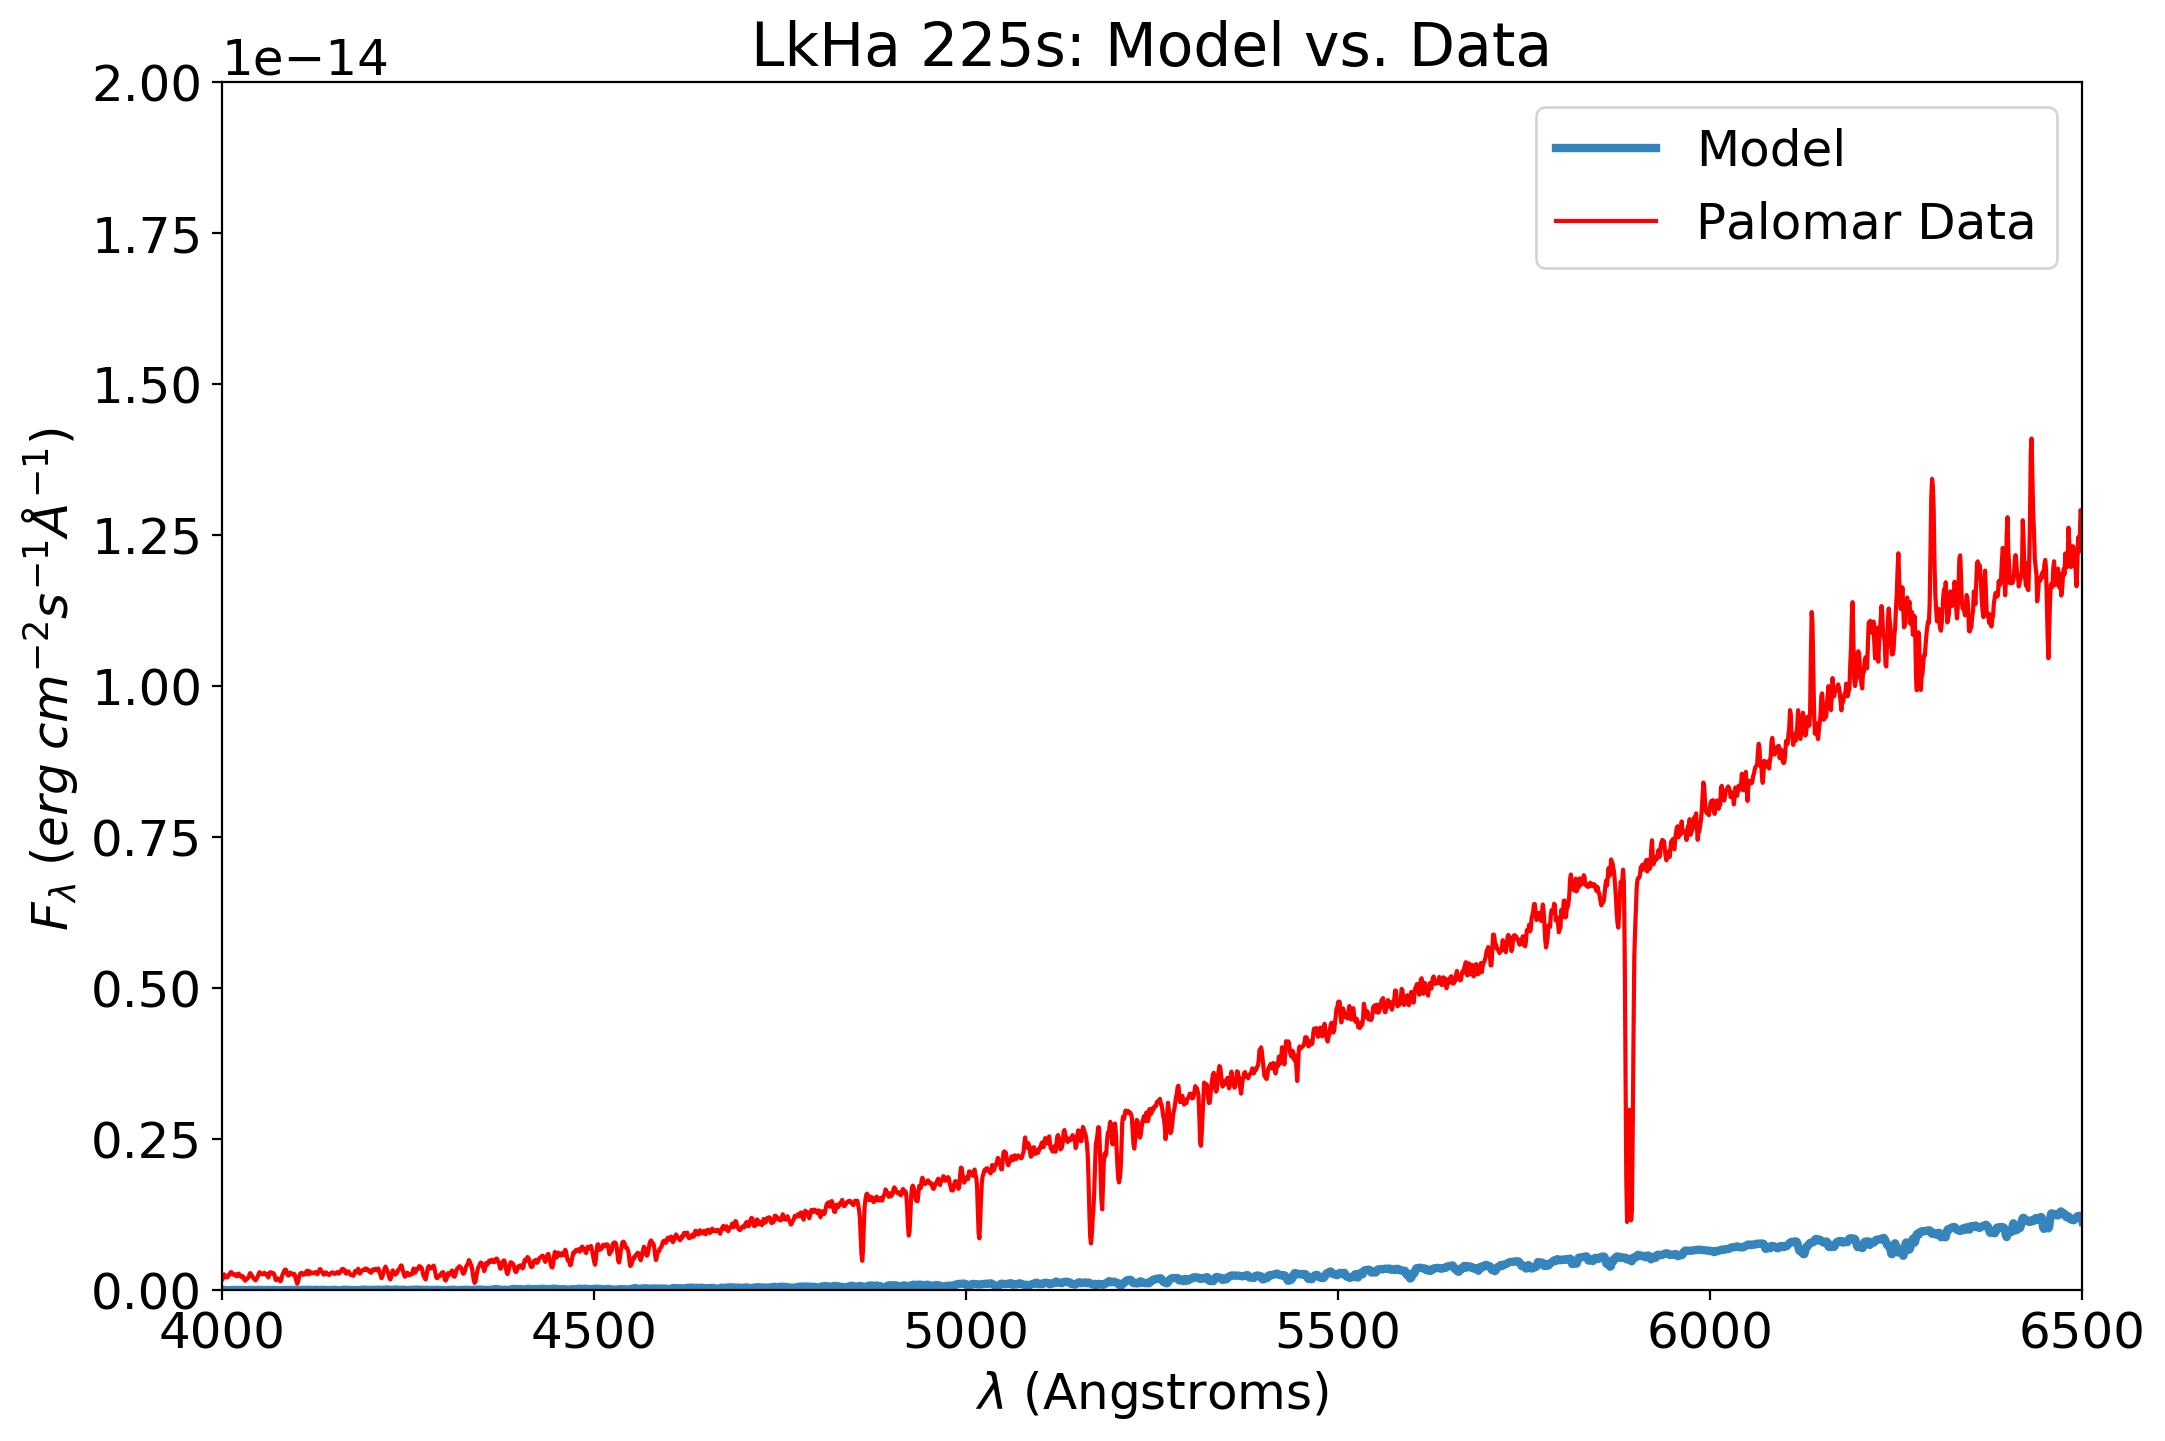

In [174]:
fig=plt.figure(figsize=(12, 8), dpi= 200)
plt.rcParams.update({'font.size': 18})
plt.title('LkHa 225s: Model vs. Data')
# plt.plot(np.array(UV_WAVES).flatten(), np.array(UV_FLUXES).flatten()*1e-8, lw=3, \
#     alpha=0.9,label=r'HBC 722')

plt.plot(np.array(UV_WAVES).flatten(), np.array(UV_FLUXES).flatten()*1e-8, lw=3, \
    alpha=0.9,label=r'Model')

plt.plot(waves_UV, fluxes_UV, 'r-', label='Palomar Data')
# plt.plot(waves_UV, smoothed_signal, 'r-', label='Data')


plt.xlabel(r'$\lambda$ (Angstroms)')
plt.ylabel(r' $F_\lambda\; (erg \;cm^{-2} s^{-1} \AA^{-1})$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.ylim(0,0.2e-13)
plt.xlim(4000,6500)
# plt.xticks(np.arange(1950, 4550, 50))
# plt.savefig('fu_ori_hst_comparison_using_sed_extended.png', dpi = 200, bbox_inches='tight')
plt.show()

### Writing out

In [175]:
def find_nearest(array, value, side):
    array = np.asarray(array)
    min_vals = array-value
    max_vals = -min_vals
    if side == 'above':
        for i in range(len(min_vals)):
            if min_vals[i] < 0: min_vals[i] = np.inf
        idx = min_vals.argmin()
    if side == 'below':
        for i in range(len(min_vals)):
            if max_vals[i] < 0: max_vals[i] = np.inf
        idx = max_vals.argmin()
    return array[idx]

In [176]:
wav_OUT, flux_OUT = np.array(UV_WAVES).flatten(), np.array(UV_FLUXES).flatten()*1e-8

In [177]:
wav_OUT

array([3900, 3901, 3902, ..., 8897, 8898, 8899])

In [178]:
LOW_LIM_DATA = 4000
HIGH_LIM_DATA =8999

In [179]:
IND_LOW_DATA = np.searchsorted(wav_OUT, LOW_LIM_DATA)
IND_HIGH_DATA = np.searchsorted(wav_OUT, HIGH_LIM_DATA)

In [180]:
WAV_OUT = wav_OUT[IND_LOW_DATA:IND_HIGH_DATA+1]
FLUX_OUT = flux_OUT[IND_LOW_DATA:IND_HIGH_DATA+1]

In [181]:
import csv
with open('lkha225s_model_5400K.txt', 'w') as f:
    writer = csv.writer(f, delimiter=' ',  lineterminator = '\n')
    writer.writerows(zip(WAV_OUT, FLUX_OUT))